# 1. Importing relevant packages

In [ ]:
import os
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import pickle
import pandas_datareader as web
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adadelta, Adam, Adamax, Adagrad, SGD, RMSprop

# 3. Get the stock data

Following are the tickers I am going to use:
* AMZN [Amazon] - No
* AAPL [Apple]  - Yes
* FB [Facebook] - Yes
* GOOGL [Google] - No
* HDB [HDFC Bank Limited] - Yes
* MSFT [Microsoft] - Yes
* NFLX [Netflix] - No
* RELIANCE.NS [Reliance Industries Limited] - No
* TSLA [Tesla, Inc.] - Yes

In [ ]:
ticker = 'AAPL'
comp = 'Apple'
end_date = str(date.today())
df = web.DataReader(ticker, data_source='yahoo', start='2010-01-01', end=end_date)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.539882
2010-01-05,7.699643,7.616071,7.664286,7.656428,601904800.0,6.551187
2010-01-06,7.686786,7.526786,7.656428,7.534643,552160000.0,6.446983
2010-01-07,7.571429,7.466072,7.562500,7.520714,477131200.0,6.435065
2010-01-08,7.571429,7.466429,7.510714,7.570714,447610800.0,6.477847
...,...,...,...,...,...,...
2020-12-07,124.570000,122.250000,122.309998,123.750000,86712000.0,123.750000
2020-12-08,124.980003,123.089996,124.370003,124.379997,82225500.0,124.379997
2020-12-09,125.949997,121.000000,124.529999,121.779999,115089200.0,121.779999


# About the Data

**High** : The highest record of stock price on that day. 

**Low** : The lowest record of stock price on that day.

**Open** : Actual stock value when the market opened for the day.

**Close** : Actual stock value when the market closed for the day. 

**Volume** : Number of shares that changed hands during a given day. Number of shares of a security traded between its daily open and close.

**Adj Close** :  The adjusted closing price factors in anything that might affect the stock price after the market closes. The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. 

# Data Summary

In [ ]:
# No. of records and Features
print("NO. OF RECORDS AND FEATURES :\n")
print("No. of Records : {}".format(df.shape[0]))
print("No. of Features : {}".format(df.shape[1]))
print("----------------------------------------------------------------\n")
# Datatypes of features
print("DATATYPES OF FEATURES :\n")
print(df.info())
print("----------------------------------------------------------------\n")
# Descriptive Statistics
print("DESCRIPTIVE STATISTICS :\n")
df.describe()

NO. OF RECORDS AND FEATURES :

No. of Records : 2756
No. of Features : 6
----------------------------------------------------------------

DATATYPES OF FEATURES :

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2756 entries, 2010-01-04 to 2020-12-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2756 non-null   float64
 1   Low        2756 non-null   float64
 2   Open       2756 non-null   float64
 3   Close      2756 non-null   float64
 4   Volume     2756 non-null   float64
 5   Adj Close  2756 non-null   float64
dtypes: float64(6)
memory usage: 150.7 KB
None
----------------------------------------------------------------

DESCRIPTIVE STATISTICS :



,High,Low,Open,Close,Volume,Adj Close
count,2756.000000,2756.000000,2756.000000,2756.000000,2.756000e+03,2756.000000
mean,33.653313,32.963628,33.308975,33.322264,2.863065e+08,31.447068
std,24.027927,23.371081,23.703067,23.715714,2.301148e+08,24.132892
min,7.000000,6.794643,6.870357,6.858929,2.019780e+07,5.868809
25%,17.602678,17.273481,17.451696,17.443750,1.190794e+08,15.304076
50%,27.188750,26.631250,26.911249,26.922500,2.039756e+08,24.695399
75%,43.183124,42.430001,42.801250,42.775626,3.903438e+08,41.106130
max,137.979996,130.529999,137.589996,134.179993,1.880998e+09,133.948898


## Visualizing the Data

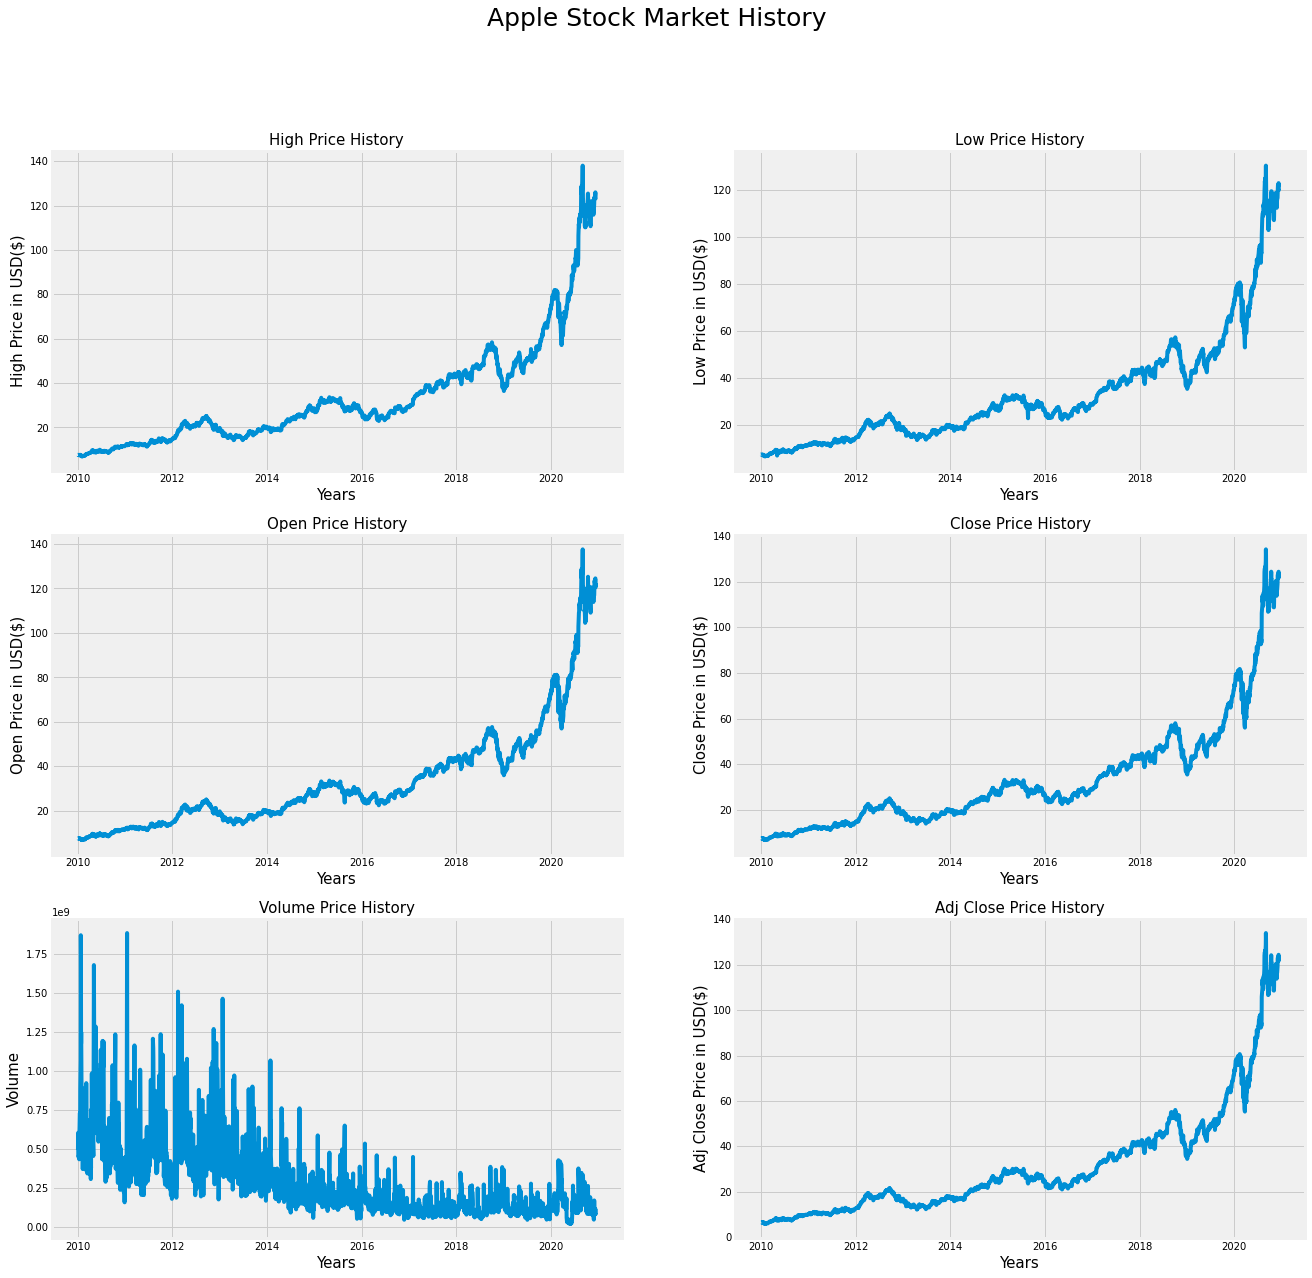

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(20,20))
plt.suptitle(comp + " Stock Market History", fontsize=25)

ax[0,0].set_title("High Price History", fontsize=15)
ax[0,0].plot(df.index, df['High'])
ax[0,0].set_xlabel('Years', fontsize=15)
ax[0,0].set_ylabel('High Price in USD($)', fontsize=15)

ax[0,1].set_title("Low Price History", fontsize=15)
ax[0,1].plot(df.index, df['Low'])
ax[0,1].set_xlabel('Years', fontsize=15)
ax[0,1].set_ylabel('Low Price in USD($)', fontsize=15)

ax[1,0].set_title("Open Price History", fontsize=15)
ax[1,0].plot(df.index, df['Open'])
ax[1,0].set_xlabel('Years', fontsize=15)
ax[1,0].set_ylabel('Open Price in USD($)', fontsize=15)

ax[1,1].set_title("Close Price History", fontsize=15)
ax[1,1].plot(df.index, df['Close'])
ax[1,1].set_xlabel('Years', fontsize=15)
ax[1,1].set_ylabel('Close Price in USD($)', fontsize=15)

ax[2,0].set_title("Volume Price History", fontsize=15)
ax[2,0].plot(df.index, df['Volume'])
ax[2,0].set_xlabel('Years', fontsize=15)
ax[2,0].set_ylabel('Volume', fontsize=15)

ax[2,1].set_title("Adj Close Price History", fontsize=15)
ax[2,1].plot(df.index, df['Adj Close'])
ax[2,1].set_xlabel('Years', fontsize=15)
ax[2,1].set_ylabel('Adj Close Price in USD($)', fontsize=15)

plt.show()

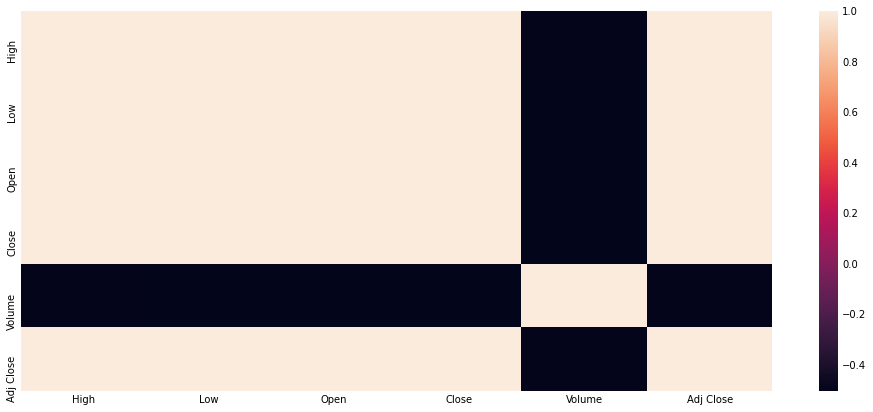

In [ ]:
plt.figure(figsize=(15,7))
corr_mat = df.corr()
sns.heatmap(corr_mat)
plt.show()

### All features except `Volume` are highly correlated with each other. But we are only interested in `Close` feature for forecasting. Hence, we won't discard any feature.

# 3. Data Preparation

## 3.1 Let's look for any missing data here

MISSING DATA FEATUREWISE :

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64 



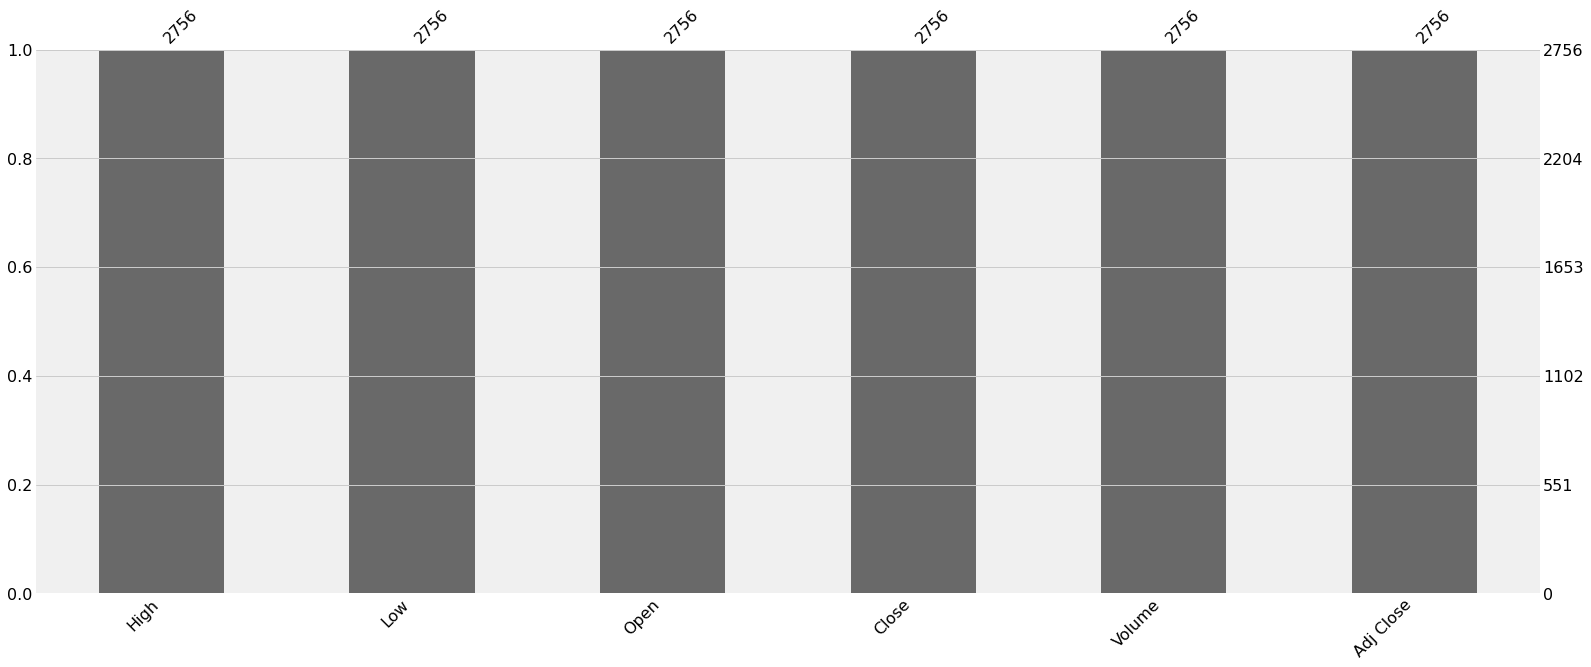

In [ ]:
print("MISSING DATA FEATUREWISE :\n")
print(df.isnull().sum(),"\n")
missingno.bar(df)
plt.show()

### We can confirm that there are no missing records present in data.

#### Now, we are only interested in `Close` feature. Hence, we extract it.

In [ ]:
data = df['Close'].values
print(f'There are {data.shape[0]} records in Close feature')

There are 2756 records in Close feature



Now, we will perform the following steps so that our time series data is ready to use:

1. Convert problem to a <font color='yellow'>**supervised learning problem**</font>.

2. <font color='yellow'>**Scale the data**</font>, specifically between -1 and 1 to meet the default hyperbolic tangent activation function of LSTM models.


<h1 align='center'><font color='orange'>Important Note</h1></font>

**<h6 align='center'>In time series analysis and forecasting using LSTMs, stationary data is not necessary.**

Models like ARIMA require a stationarized time series for forecasting as it's statistical properties like mean, variance, autocorrelation etc are constant over time (locally stationary). But we do not need to check for stationarity nor correct for it when we are using an LSTM since RNNs have a better capacity to learn non-linear relationships and perform better than traditional time series models when the data is large.

Unlike ARIMA, RNNs are capable of learning nonlinearities, and specialized nodes like LSTM nodes are even better at this. In particular, LSTMs and GRUs are very good at learning long-term dependencies. Effectively this means that what is meant by 'stationarity' is less brittle with RNNs, so it's somewhat less of a concern. To be able to learn long term dependencies, however, you need LOTS of data to train on.
</h6>
<br>

Q. Why do we need data to be stationary when using models like ARIMA/ SARIMAX?<br>
A. Time series have the additional complexity that there may be long term structure in your data that your model may not be sophisticated enough to learn. For example, when using an autoregressive lag of N, we can't learn dependencies over intervals longer than N. Hence, when using simple models like ARIMA, we want data to also be locally stationary.


For More info, read following articles and answers:
1. https://bit.ly/31CrqTk
2. https://bit.ly/31wcLsP

**<font color='yellow'>NOTE : </font>For forecasting, we will be using previous 90 days data to predict the next day data. Keeping this in mind, let's build training and test set. We will be forecasting stock prices between 1 to 7 future days.** 

## Preparing data matrix where each record has 90 days data(i.e 90 columns) and target feature has next 1 day price.

In [ ]:
def prepare_data_matrix(data):
    X, y = [], []
    for i in range(0, len(data)-90):
        X.append(data[i:i+90])
        y.append(data[i+90])

    # convert X and y to numpy array
    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = prepare_data_matrix(data)

# shape of X and y
print("X shape : ", X.shape)
print("y shape : ", y.shape)

X shape :  (2666, 90)
y shape :  (2666,)


## Splitting data into train and test set

In [ ]:
# Splitting data into train and test - 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))

X_train shape : (2132, 90)
X_test shape : (534, 90)


## Scaling Data

We will now scale our data. Generally, scaling the data is a good practice when using neural networks

In [ ]:
# Scaling train data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
# Scaling test data
X_test = scaler.transform(X_test)

In [ ]:
# Reshape train and test data to above format
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)

X_train Shape :  (2132, 90, 1)
X_test Shape :  (534, 90, 1)


**We are now ready with the data and in a position to build and train our model.**

# LSTM Variation Selection + Benchmark Score Selection + Model Architecture Selection

## Few things to note before I start...

1. I will try the following LSTM variations and see which variation performs best for us and select that one for further use.

  * Vanilla LSTM (1 layer)
  * Stacked LSTM (> 1 layer)

2. I will be trying out these variations with below configurations for all models :

  * No. of neurons in LSTM layer = 3
  * Batch Size = 64
  * Epochs = 1000 (with early stopping callback)

3. To evaluate our models, we will be using <u>Root Mean Squared Error (RMSE)</u> throughout. Lower the RMSE value, better is the model. 

4. <u>Lowest RMSE score from the variation models will be chosen as Benchmark score</u> and updated as we keep on experimenting.

5. I will try each <u>experiment for 5 iterations per model</u> to generalize the conclusions.

6. To keep a check on overfitting due to epochs, I will use <u>Early Stopping Callback</u> to stop training when model performance stops improving. Controlling the number of epochs is really crucial because this will :
  * Prevent overfitting of model.
  * Reduce computational cost of training model and increase training speed. 
  * Reduce computational cost of experimenting with different configurations.

In [ ]:
# Configurations for NN
NUM_UNITS = 3
BATCH_SIZE = 64
EPOCHS = 1000
NUM_FEATURES = 1

In [ ]:
def rmse(y_preds, y_test):
  mse = mean_squared_error(y_preds, y_test)
  rmse = np.sqrt(mse)
  return rmse

In [ ]:
'''
Defining an early stopping callback which will monitor validation loss and check
for improvement for 5 iterations post which it will stop the learning process.
'''
def earlyStopping():
  esCallback = EarlyStopping(monitor='val_loss', 
                             mode='auto',
                             patience=5,
                             verbose=2,
                             restore_best_weights=True
                            )
  return esCallback

To use Early Stopping, we will need a validation data as Early Stopping will monitor the validation loss. Let's create one

In [ ]:
# Splitting train data into train and validation data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Experiment for LSTM Variation - Vanilla or Stacked ?

To see which variation works best for us, I will be trying out 5 layers in total
  * No. of layer = [1, 2, 3, 4, 5]

Total 25 models => 5 layers * 5 iterations each

In [ ]:
def build_model(lstm_layers):
  model = Sequential()
  if lstm_layers == 1:
    model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES)))
  elif lstm_layers == 2:
    model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES), return_sequences=True))
    model.add(LSTM(units=3))
  elif lstm_layers == 3:
    model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES), return_sequences=True))
    model.add(LSTM(units=3, return_sequences=True))
    model.add(LSTM(units=3))
  elif lstm_layers == 4:
    model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES), return_sequences=True))
    model.add(LSTM(units=3, return_sequences=True))
    model.add(LSTM(units=3, return_sequences=True))
    model.add(LSTM(units=3))
  else:
    model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES), return_sequences=True))
    model.add(LSTM(units=3, return_sequences=True))
    model.add(LSTM(units=3, return_sequences=True))
    model.add(LSTM(units=3, return_sequences=True))
    model.add(LSTM(units=3))
  # model.add(Dense(units=20))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
# Fit 5 models per variation i.e 10 models total
model_cnt=1
mean_rmse_score = []
nb_layers = [1,2,3,4,5]
for layers in nb_layers:
    rmse_scores = []
    for i in range(5): 
        print("Training model : {}/25".format(model_cnt))
        model = build_model(layers)
        model.fit(X_tr, y_tr,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=(X_val, y_val),
                  callbacks=[earlyStopping()],
                  verbose=2
                )
        # Prediction
        y_preds = model.predict(X_test)
        # Compute RMSE and store
        rmse_scores.append(rmse(y_preds, y_test))
        model_cnt+=1
    # Maitaining mean RMSE score for each variation model
    mean_rmse_score.append(np.mean(rmse_scores))

Training model : 1/25
Epoch 1/1000
27/27 - 1s - loss: 1736.3676 - val_loss: 1682.5823
Epoch 2/1000
27/27 - 1s - loss: 1730.6609 - val_loss: 1677.1422
Epoch 3/1000
27/27 - 1s - loss: 1725.0222 - val_loss: 1671.3671
Epoch 4/1000
27/27 - 1s - loss: 1718.4789 - val_loss: 1663.8160
Epoch 5/1000
27/27 - 1s - loss: 1709.1584 - val_loss: 1652.2820
Epoch 6/1000
27/27 - 1s - loss: 1693.7955 - val_loss: 1632.4891
Epoch 7/1000
27/27 - 1s - loss: 1669.6737 - val_loss: 1605.0485
Epoch 8/1000
27/27 - 1s - loss: 1641.7792 - val_loss: 1580.7059
Epoch 9/1000
27/27 - 1s - loss: 1621.7411 - val_loss: 1564.2727
Epoch 10/1000
27/27 - 1s - loss: 1606.1515 - val_loss: 1549.8481
Epoch 11/1000
27/27 - 1s - loss: 1592.0399 - val_loss: 1536.3076
Epoch 12/1000
27/27 - 1s - loss: 1578.7162 - val_loss: 1523.6321
Epoch 13/1000
27/27 - 1s - loss: 1566.1497 - val_loss: 1511.6747
Epoch 14/1000
27/27 - 1s - loss: 1554.2970 - val_loss: 1500.3074
Epoch 15/1000
27/27 - 1s - loss: 1543.0455 - val_loss: 1489.4838
Epoch 16/100

In [ ]:
# Scoring DataFrame:
nblayers_rmse_df = pd.DataFrame({"LSTM layers" : [1, 2, 3, 4, 5],
                                 "RMSE Scores" : mean_rmse_score
                                })
nblayers_rmse_df

,LSTM layers,RMSE Scores
0,1,4.622546
1,2,5.057906
2,3,15.934067
3,4,12.722955
4,5,19.136853


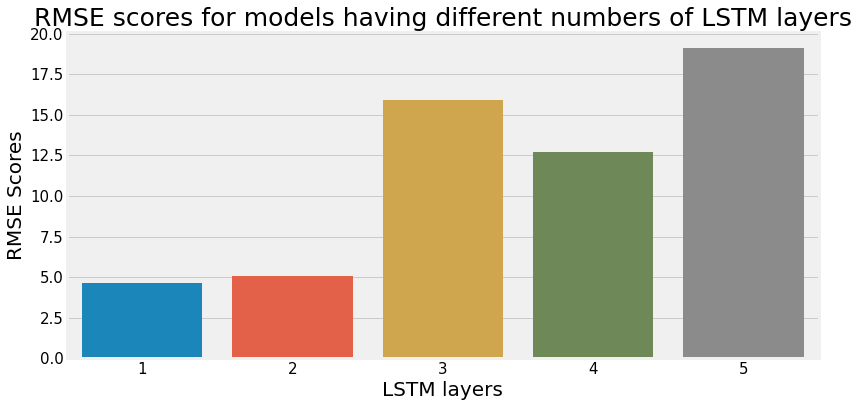

In [ ]:
plt.figure(figsize=(12,6))
plt.title("RMSE scores for models having different numbers of LSTM layers", fontsize=25)
plt.xlabel("No. of layers", fontsize=20)
plt.ylabel("RMSE score", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.barplot(nblayers_rmse_df['LSTM layers'], nblayers_rmse_df['RMSE Scores'])
plt.show()

## **We can confirm visually that we got the <u>least RMSE with Vanilla LSTM</u> i.e. with a single LSTM layer. Moving forward, we will use Vanilla LSTMs and its RMSE score as Becnhmark for further experimenting and for model building and training purpose.**

## *Benchmark Score = 4.6225*

## Experiment for Batch Size -

I will be trying out the following values 
  * Batch size = [4, 8, 16, 32, 64, 128]

Total 30 model => 6 batch sizes * 5 iterations each

In [ ]:
def build_model():
  model = Sequential()
  model.add(LSTM(units=NUM_UNITS, input_shape=(X_train.shape[1], NUM_FEATURES)))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
model_cnt = 1
mean_rmse_scores = []
batches = [4, 8, 16, 32, 64, 128]
for batch_size in batches:
    rmse_scores = []
    for i in range(5):
        print("Training model : {}/30".format(model_cnt))
        model = build_model()
        model.fit(X_tr, y_tr,
                  epochs=EPOCHS,
                  batch_size=batch_size,
                  validation_data=(X_val, y_val),
                  callbacks=[earlyStopping()],
                  verbose=2
                )
        # Prediction
        y_preds = model.predict(X_test)
        # Compute RMSE and store
        rmse_scores.append(rmse(y_preds, y_test))
        model_cnt+=1
    # Maintaining the mean RMSE scores for each batch size
    mean_rmse_scores.append(np.mean(rmse_scores))

Streaming output truncated to the last 5000 lines.
14/14 - 0s - loss: 213.7731 - val_loss: 257.5695
Epoch 959/1000
14/14 - 0s - loss: 213.3422 - val_loss: 257.1056
Epoch 960/1000
14/14 - 0s - loss: 212.9460 - val_loss: 256.6295
Epoch 961/1000
14/14 - 0s - loss: 212.5417 - val_loss: 256.1452
Epoch 962/1000
14/14 - 0s - loss: 212.1450 - val_loss: 255.6963
Epoch 963/1000
14/14 - 0s - loss: 211.7257 - val_loss: 255.2313
Epoch 964/1000
14/14 - 0s - loss: 211.3277 - val_loss: 254.7460
Epoch 965/1000
14/14 - 0s - loss: 210.9090 - val_loss: 254.2588
Epoch 966/1000
14/14 - 0s - loss: 210.5092 - val_loss: 253.7985
Epoch 967/1000
14/14 - 0s - loss: 210.1091 - val_loss: 253.3268
Epoch 968/1000
14/14 - 0s - loss: 209.6895 - val_loss: 252.8567
Epoch 969/1000
14/14 - 0s - loss: 209.2745 - val_loss: 252.3459
Epoch 970/1000
14/14 - 0s - loss: 208.8601 - val_loss: 251.8758
Epoch 971/1000
14/14 - 0s - loss: 208.4541 - val_loss: 251.4108
Epoch 972/1000
14/14 - 0s - loss: 208.0492 - val_loss: 250.9258
Epoc

In [ ]:
# Scoring dataframe
batchsize_rmse_df = pd.DataFrame({"Batch Size" : [str(x) for x in batches],
                                 "RMSE Scores" : mean_rmse_scores
                                })
batchsize_rmse_df = batchsize_rmse_df.sort_values("RMSE Scores").head()
batchsize_rmse_df

,Batch Size,RMSE Scores
3,32,1.134050
0,4,1.134207
2,16,1.147986
1,8,1.148209
4,64,4.557797


[]

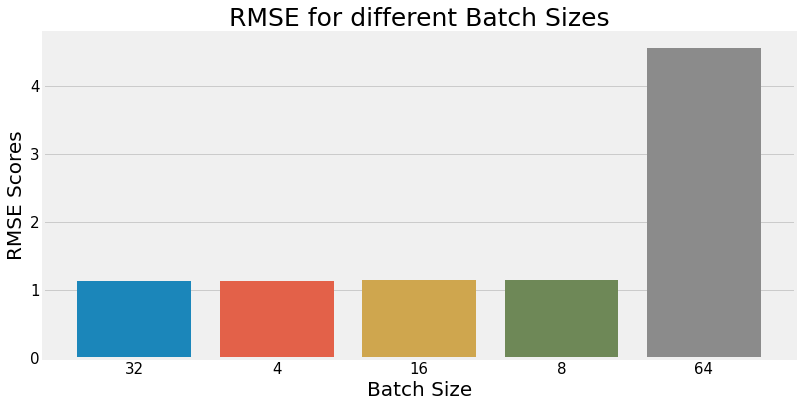

In [ ]:
plt.figure(figsize=(12,6))
plt.title("RMSE for different Batch Sizes", fontsize=25)
plt.xlabel("Batch Size", fontsize=20)
plt.ylabel("RMSE Score", fontsize=20)
sns.barplot(batchsize_rmse_df['Batch Size'], batchsize_rmse_df['RMSE Scores'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot()

### <u>Batch size of 32 gave the best results</u> beating the benchmark RMSE score. Thus, I will go with a batch size of 32.


## *Updated Benchmark score = 1.1341*

# Experiment for No. of Neurons in LSTM layer

I will be trying out the following values:
  * Neurons = [2, 3, 4, 5, 6]

Total 25 models => 5 Neurons * 5 Iterations



In [ ]:
def build_model(neurons):
  model = Sequential()
  model.add(LSTM(units=neurons, input_shape=(X_train.shape[1], NUM_FEATURES)))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
start = time.time()
cnt=1
mean_rmse = []
neurons_list = [2, 3, 4, 5, 6]
for neurons in neurons_list:
  rmse_scores = []
  for i in range(5):
    print("Training Model " + str(cnt) + "/25")
    model = build_model(neurons)
    model.fit(X_tr, y_tr,
              epochs=EPOCHS,
              batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[earlyStopping()],
              verbose=2
            )
    # Prediction
    y_preds = model.predict(X_test)
    rmse_scores.append(rmse(y_preds, y_test))
    cnt+=1
  # Compute mean RMSE and store
  mean_rmse.append(np.mean(rmse_scores))
print("Total time taken to train = {:.2f} minutes".format((time.time() - start) / 60))

Streaming output truncated to the last 5000 lines.
Epoch 337/1000
54/54 - 1s - loss: 38.9825 - val_loss: 37.9271
Epoch 338/1000
54/54 - 1s - loss: 38.4864 - val_loss: 37.4659
Epoch 339/1000
54/54 - 1s - loss: 38.0146 - val_loss: 36.8427
Epoch 340/1000
54/54 - 1s - loss: 37.5048 - val_loss: 36.4266
Epoch 341/1000
54/54 - 1s - loss: 37.0352 - val_loss: 36.0859
Epoch 342/1000
54/54 - 1s - loss: 36.5722 - val_loss: 35.7229
Epoch 343/1000
54/54 - 1s - loss: 36.1346 - val_loss: 34.9264
Epoch 344/1000
54/54 - 1s - loss: 35.5917 - val_loss: 34.5061
Epoch 345/1000
54/54 - 1s - loss: 35.2037 - val_loss: 34.1152
Epoch 346/1000
54/54 - 1s - loss: 34.7103 - val_loss: 33.5070
Epoch 347/1000
54/54 - 1s - loss: 34.2236 - val_loss: 33.2151
Epoch 348/1000
54/54 - 1s - loss: 33.7814 - val_loss: 32.7239
Epoch 349/1000
54/54 - 1s - loss: 33.3959 - val_loss: 32.4103
Epoch 350/1000
54/54 - 1s - loss: 32.9131 - val_loss: 31.8333
Epoch 351/1000
54/54 - 1s - loss: 32.4610 - val_loss: 31.3910
Epoch 352/1000
54/5

In [ ]:
# RMSE Score DataFrame
neurons_rmse_df = pd.DataFrame({"No. of neurons" : [str(x) for x in neurons_list],
                                "RMSE Scores" : mean_rmse})
neurons_rmse_df.sort_values("RMSE Scores").head()

,No. of neurons,RMSE Scores
2,4,1.238738
1,3,1.249499
0,2,1.300190
4,6,1.374243
3,5,1.412926


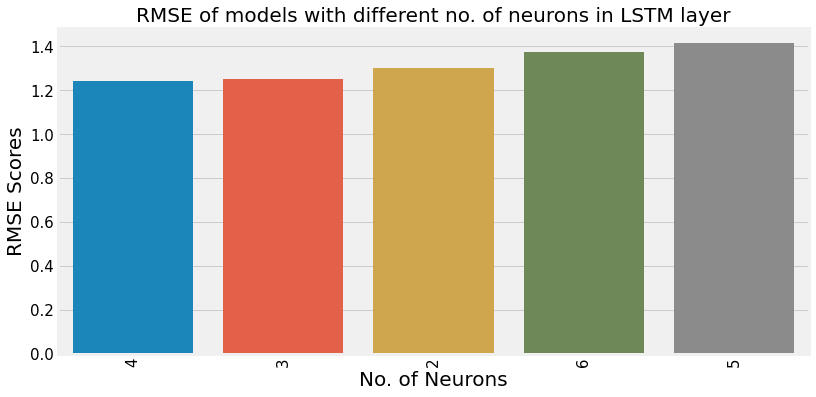

In [ ]:
plt.figure(figsize=(12,6))
sorted_df = neurons_rmse_df.sort_values("RMSE Scores")
plt.title("RMSE of models with different no. of neurons in LSTM layer", fontsize=20)
sns.barplot(x=sorted_df['No. of neurons'], y=sorted_df['RMSE Scores'])
plt.xlabel("No. of Neurons", fontsize=20)
plt.ylabel("RMSE Scores", fontsize=20)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Model with <u> 4 neurons performed the best but failed to beat the benchmark score</u>. From above experiment, we can clearly see that both 3 neurons & 4 neurons performed at par and adding extra layer to model is not worth the additional computational cost. Hence, we make no changes in model. 

## *Updated Benchmark score = 1.2495*

## Experiment for (1) No. of Dense units & (2) No. of Dense Layers
 *NOTE : I will perform this experiment in 2 parts as the notebooks keeps crashing.*

 ### PART - 1

 In this part, I would be trying out the following values for Dense units & Dense layer
 * Dense units => [16, 32, 64, 128, 256, 512, 1024]
 * Dense layers => [1, 2, 3, 4]

 Total 140 model => 7 dense units * 4 dense layers * 5 iterations each

In [ ]:
# Model architectures with different number of Dense units and Dense Layers
def build_model(dense_units, dense_layers):
  model = Sequential()
  model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES)))
  if dense_layers == 1:
    model.add(Dense(units=dense_units))
  elif dense_layers == 2:
    model.add(Dense(units=dense_units))
    model.add(Dense(units=dense_units/2))
  elif dense_layers == 3:
    model.add(Dense(units=dense_units))
    model.add(Dense(units=dense_units/2))
    model.add(Dense(units=dense_units/4))
  else:
    model.add(Dense(units=dense_units))
    model.add(Dense(units=dense_units/2))
    model.add(Dense(units=dense_units/4))
    model.add(Dense(units=dense_units/8))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
start = time.time()
cnt=1
rmse_scores_dict = {}
dense_units_list = [16, 32, 64, 128, 256, 512, 1024]
dense_layers_list = [1, 2, 3, 4]
for dense_layers in dense_layers_list:
  for dense_units in dense_units_list:
    model_name = "model_" + str(dense_units) + "_units_" + str(dense_layers) + "_layers" 
    rmse_scores = []
    for i in range(5):
      print("Training Model " + str(cnt) + "/140")
      model = build_model(dense_units, dense_layers)
      model.fit(X_tr, y_tr,
                epochs=EPOCHS,
                batch_size=32,
                validation_data=(X_val, y_val),
                callbacks=[earlyStopping()],
                verbose=2
              )
      # Prediction
      y_preds = model.predict(X_test)
      rmse_scores.append(rmse(y_preds, y_test))
      cnt+=1
    # Compute mean RMSE and store
    mean_rmse = np.mean(rmse_scores)
    rmse_scores_dict[model_name] = mean_rmse
print("Total time taken to train = {:.2f} minutes".format((time.time() - start) / 60))

Streaming output truncated to the last 5000 lines.
Epoch 56/1000
54/54 - 1s - loss: 1.9402 - val_loss: 1.8835
Epoch 57/1000
54/54 - 0s - loss: 1.8811 - val_loss: 1.9734
Epoch 58/1000
54/54 - 0s - loss: 1.8561 - val_loss: 1.8330
Epoch 59/1000
54/54 - 0s - loss: 1.8362 - val_loss: 2.0501
Epoch 60/1000
54/54 - 0s - loss: 1.9333 - val_loss: 1.9444
Epoch 61/1000
54/54 - 0s - loss: 1.7813 - val_loss: 1.8305
Epoch 62/1000
54/54 - 0s - loss: 1.8046 - val_loss: 1.8746
Epoch 63/1000
54/54 - 0s - loss: 1.8613 - val_loss: 1.7333
Epoch 64/1000
54/54 - 0s - loss: 1.7928 - val_loss: 1.8583
Epoch 65/1000
54/54 - 0s - loss: 1.8348 - val_loss: 2.0404
Epoch 66/1000
54/54 - 0s - loss: 1.9918 - val_loss: 1.8336
Epoch 67/1000
54/54 - 0s - loss: 1.7434 - val_loss: 1.8536
Epoch 68/1000
54/54 - 0s - loss: 1.7502 - val_loss: 1.7002
Epoch 69/1000
54/54 - 0s - loss: 1.7138 - val_loss: 1.6590
Epoch 70/1000
54/54 - 0s - loss: 1.6590 - val_loss: 1.7939
Epoch 71/1000
54/54 - 0s - loss: 1.7819 - val_loss: 1.8857
Epoch

In [ ]:
# RMSE Score DataFrame
model_names = rmse_scores_dict.keys()
rmse_scores = rmse_scores_dict.values()
neuron_layer_rmse_df = pd.DataFrame({"Model" : model_names, "RMSE Scores" : rmse_scores})
neuron_layer_rmse_df.sort_values("RMSE Scores").head()

,Model,RMSE Scores
10,model_128_units_2_layers,1.219278
15,model_32_units_3_layers,1.223706
3,model_128_units_1_layers,1.227674
21,model_16_units_4_layers,1.246303
25,model_256_units_4_layers,1.247079


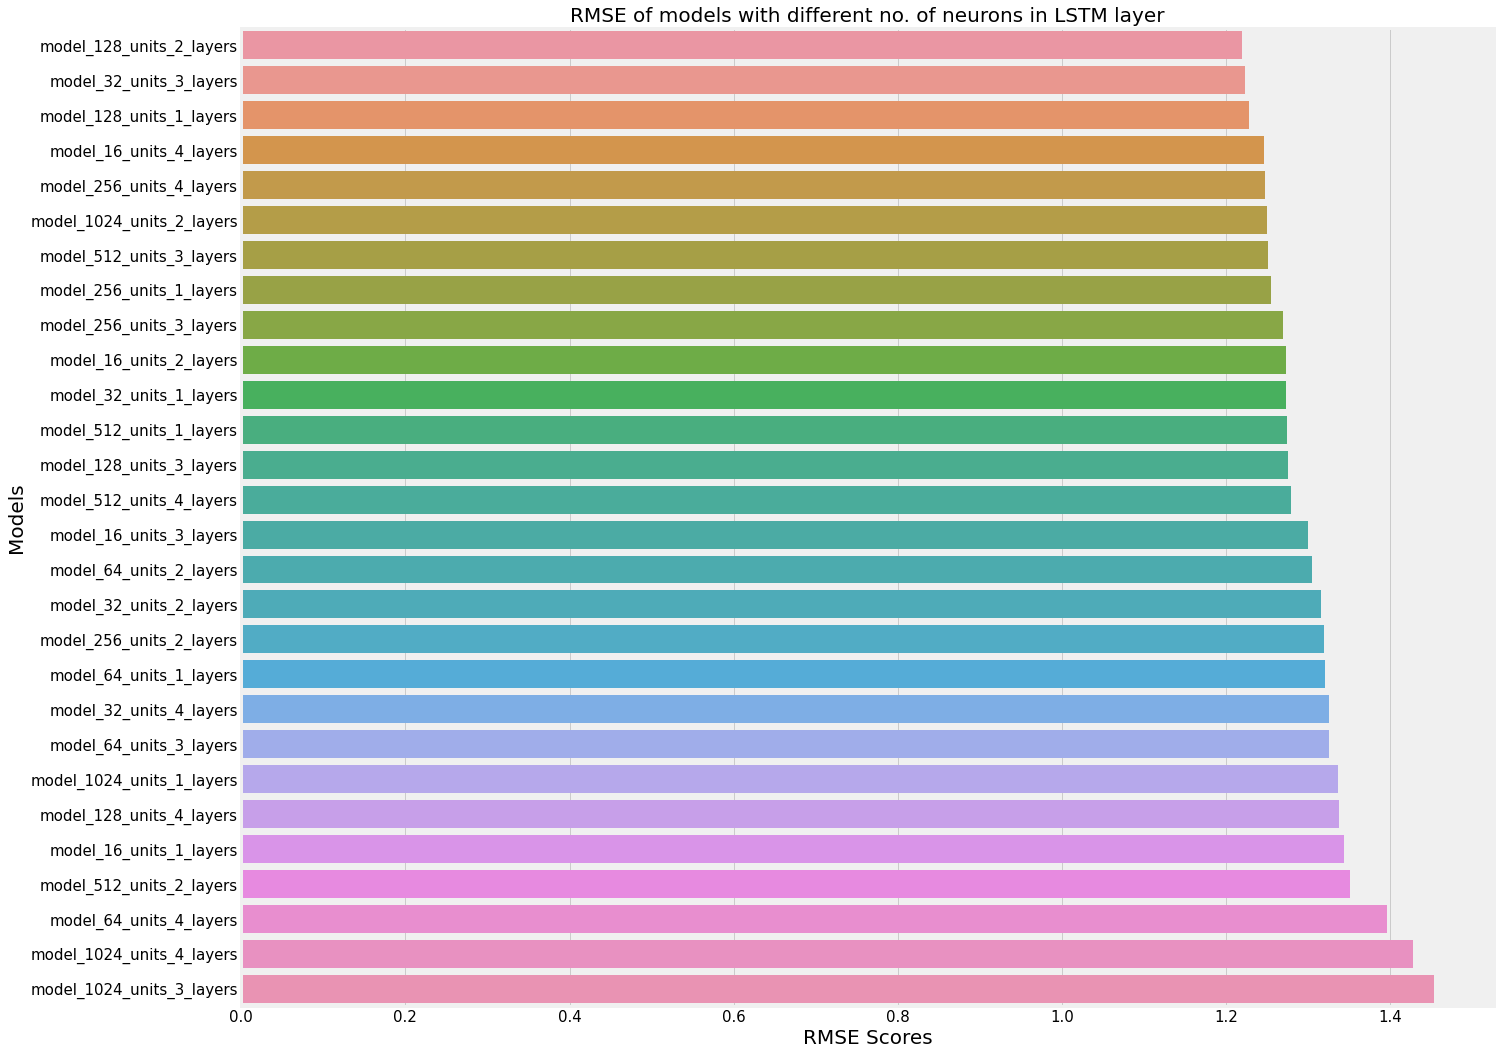

In [ ]:
plt.figure(figsize=(20,18))
sorted_df = neuron_layer_rmse_df.sort_values("RMSE Scores")
plt.title("RMSE of models with different no. of neurons in LSTM layer", fontsize=20)
splot = sns.barplot(x=sorted_df['RMSE Scores'], y=sorted_df['Model']) 
plt.xlabel("RMSE Scores", fontsize=20)
plt.ylabel("Models", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### PART - 2
In this part, I would be trying out the following values for Dense layer:
 * Dense layers => [0]

 Since there are no hidden layers and just the output layer, hence no dense units to experiment on.

 Total 5 models => 1 dense layers * 5 iterations each

In [ ]:
# Build model with 0 dense hidden layers i.e only the output layer after LSTM layer.
def build_model():
  model = Sequential()
  model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES)))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
# Fit model with no hidden layers for 5 iterations
model = build_model()
rmse_score_list = []
for i in range(5):
  print("Training model : {}/5".format(i+1))
  model.fit(X_tr, y_tr, 
            epochs=EPOCHS, 
            batch_size=32, 
            validation_data=(X_val, y_val),
            callbacks=[earlyStopping()],
            verbose=2
            )
  y_preds = model.predict(X_test)
  rmse_score_list.append(rmse(y_preds, y_test))
print("Mean RMSE score with no hidden layers is = {:.4f}".format(np.mean(rmse_score_list)))

Training model : 1/5
Epoch 1/1000
54/54 - 1s - loss: 1725.3740 - val_loss: 1687.3513
Epoch 2/1000
54/54 - 0s - loss: 1709.5428 - val_loss: 1665.6746
Epoch 3/1000
54/54 - 0s - loss: 1679.3228 - val_loss: 1629.4011
Epoch 4/1000
54/54 - 0s - loss: 1643.2924 - val_loss: 1598.8810
Epoch 5/1000
54/54 - 0s - loss: 1616.4414 - val_loss: 1575.7972
Epoch 6/1000
54/54 - 0s - loss: 1593.8629 - val_loss: 1554.8157
Epoch 7/1000
54/54 - 0s - loss: 1573.4741 - val_loss: 1535.5753
Epoch 8/1000
54/54 - 0s - loss: 1554.3591 - val_loss: 1517.7601
Epoch 9/1000
54/54 - 0s - loss: 1536.5276 - val_loss: 1500.7717
Epoch 10/1000
54/54 - 0s - loss: 1519.5319 - val_loss: 1484.5568
Epoch 11/1000
54/54 - 0s - loss: 1503.2090 - val_loss: 1469.0118
Epoch 12/1000
54/54 - 0s - loss: 1487.5067 - val_loss: 1454.0177
Epoch 13/1000
54/54 - 0s - loss: 1472.3650 - val_loss: 1439.5393
Epoch 14/1000
54/54 - 0s - loss: 1457.6450 - val_loss: 1425.4302
Epoch 15/1000
54/54 - 0s - loss: 1443.2834 - val_loss: 1411.6034
Epoch 16/1000

In [ ]:
# Add this score to previous Scoring Dataframe
no_hidden_layer_df = pd.DataFrame({"Model" : ["model_0_units_0_layers"], "RMSE Scores" : [np.mean(rmse_score_list)]})
neuron_layer_rmse_df = neuron_layer_rmse_df.append(no_hidden_layer_df, ignore_index=True)
neuron_layer_rmse_df.sort_values("RMSE Scores").head(15)

,Model,RMSE Scores
10,model_128_units_2_layers,1.219278
15,model_32_units_3_layers,1.223706
3,model_128_units_1_layers,1.227674
21,model_16_units_4_layers,1.246303
25,model_256_units_4_layers,1.247079
13,model_1024_units_2_layers,1.250618
19,model_512_units_3_layers,1.251272
4,model_256_units_1_layers,1.255378
18,model_256_units_3_layers,1.269384
7,model_16_units_2_layers,1.272882


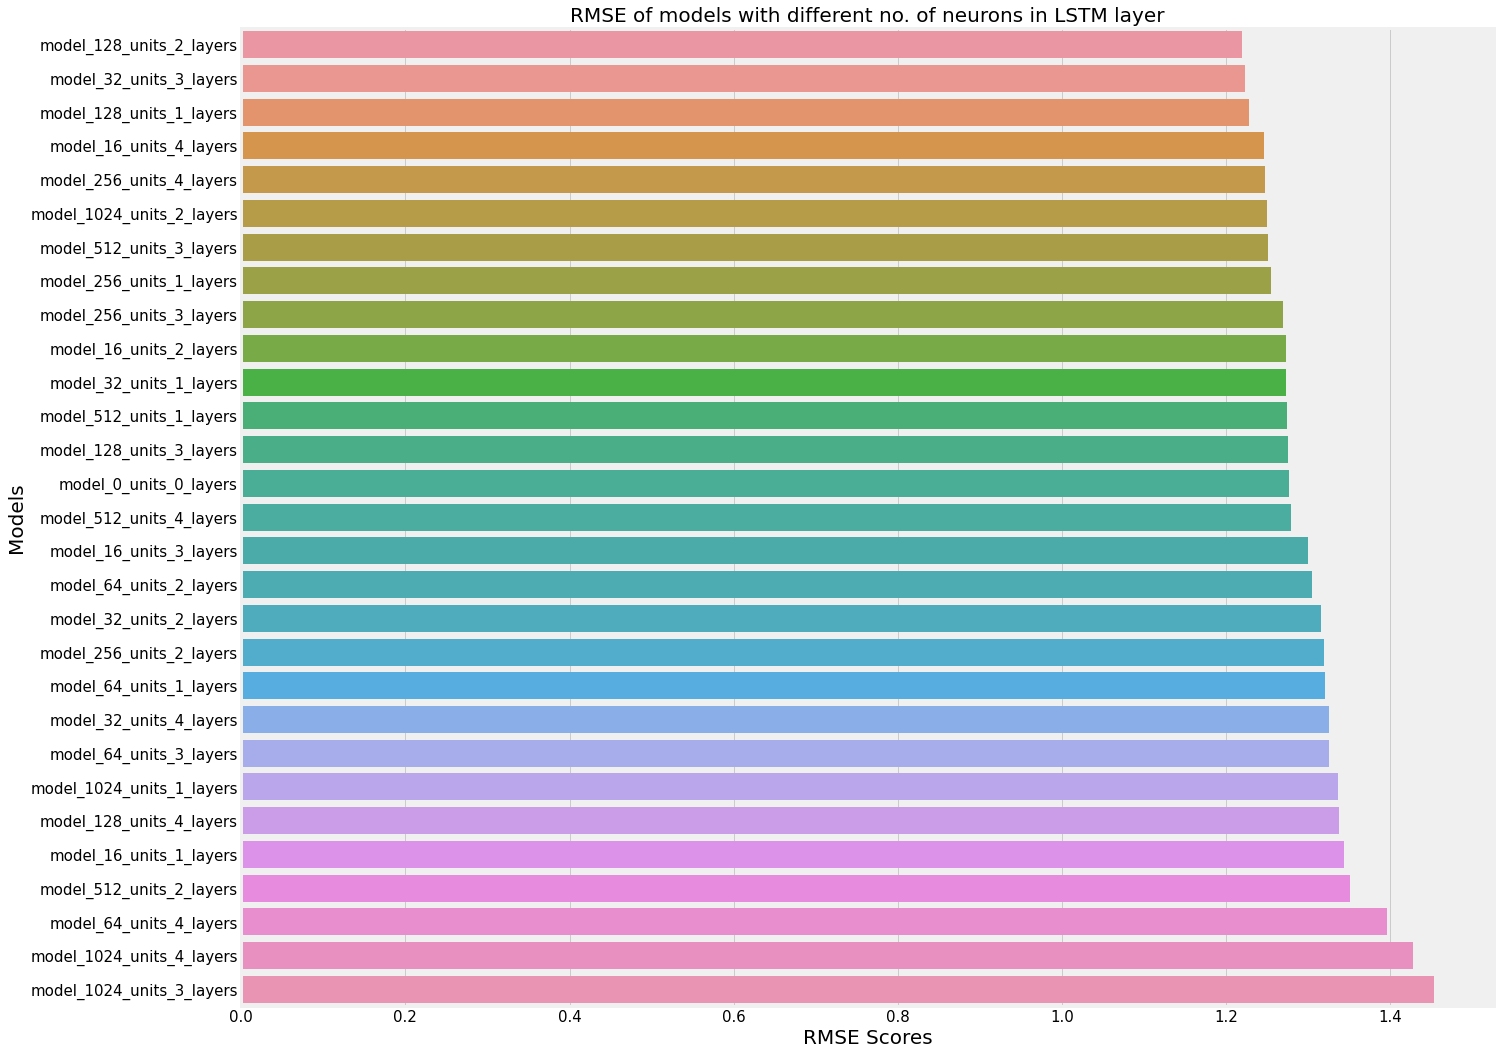

In [ ]:
plt.figure(figsize=(20,18))
sorted_df = neuron_layer_rmse_df.sort_values("RMSE Scores")
plt.title("RMSE of models with different no. of neurons in LSTM layer", fontsize=20)
splot = sns.barplot(x=sorted_df['RMSE Scores'], y=sorted_df['Model']) 
plt.xlabel("RMSE Scores", fontsize=20)
plt.ylabel("Models", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## We can see that model with <u>128 dense(hidden) units and 2 dense(hidden) layers performed best</u>. Moving forward, we will use these configurations in model architecture.

## *Updated Benchmark Score = 1.2193*

## Experiment for Activation

Let's see if adding activation increases model performance. If yes, then which one. I will try below Activation functions :
  * Activations = [ReLu, Tanh, Sigmoid, Softmax]

Total 20 model => 4 activations * 5 iterations each

In [ ]:
def build_model(activation):
  model = Sequential()
  model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES)))
  model.add(Dense(units=128))
  model.add(Activation(activation))
  model.add(Dense(units=64))
  model.add(Activation(activation))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
# Fit model with both activation function
start = time.time()
model_cnt = 1
mean_rmse_score = []
activation_list = ['relu', 'tanh', 'sigmoid', 'softmax']
for activation_fn in activation_list:
  rmse_scores = []
  for i in range(5):
    print("Training model : {}/20".format(model_cnt))
    model = build_model(activation_fn)
    model.fit(X_tr, y_tr,
              epochs=EPOCHS,
              batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[earlyStopping()],
              verbose=2
              )
    # Prediction
    y_preds = model.predict(X_test) 
    rmse_scores.append(rmse(y_preds, y_test))
    model_cnt+=1
  mean_rmse_score.append(np.mean(rmse_scores))
print("Time taken to execute cell : {:.2f} minutes".format((time.time()-start)/60))

Streaming output truncated to the last 5000 lines.
54/54 - 0s - loss: 12.0439 - val_loss: 13.1661
Epoch 63/1000
54/54 - 0s - loss: 11.3493 - val_loss: 12.2025
Epoch 64/1000
54/54 - 0s - loss: 10.5214 - val_loss: 11.2970
Epoch 65/1000
54/54 - 0s - loss: 9.6377 - val_loss: 10.3820
Epoch 66/1000
54/54 - 0s - loss: 8.9852 - val_loss: 9.7217
Epoch 67/1000
54/54 - 0s - loss: 8.3287 - val_loss: 8.9337
Epoch 68/1000
54/54 - 0s - loss: 7.7673 - val_loss: 8.4479
Epoch 69/1000
54/54 - 0s - loss: 7.1604 - val_loss: 7.5620
Epoch 70/1000
54/54 - 0s - loss: 6.6704 - val_loss: 7.1683
Epoch 71/1000
54/54 - 0s - loss: 6.1932 - val_loss: 6.6138
Epoch 72/1000
54/54 - 0s - loss: 5.8112 - val_loss: 6.1404
Epoch 73/1000
54/54 - 0s - loss: 5.4523 - val_loss: 6.2404
Epoch 74/1000
54/54 - 0s - loss: 5.0990 - val_loss: 5.2682
Epoch 75/1000
54/54 - 0s - loss: 4.6737 - val_loss: 4.7678
Epoch 76/1000
54/54 - 0s - loss: 4.3029 - val_loss: 4.4500
Epoch 77/1000
54/54 - 0s - loss: 4.0185 - val_loss: 4.0495
Epoch 78/100

In [ ]:
# Scoring dataFrame 
activation_rmse_df= pd.DataFrame({'Activation Function' : activation_list,
                                  'RMSE Scores' : mean_rmse_score
                                })
activation_rmse_df.sort_values(by='RMSE Scores')

,Activation Function,RMSE Scores
0,relu,1.277611
1,tanh,1.351719
2,sigmoid,11.408005
3,softmax,22.291590


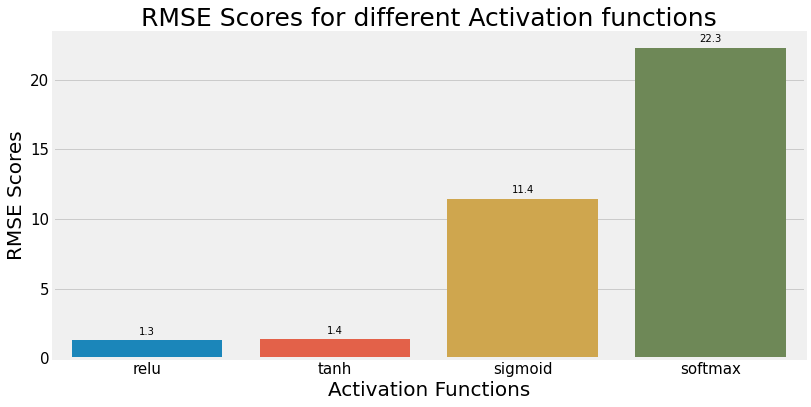

In [ ]:
# Plot for RMSE score
plt.figure(figsize=(12,6))
plt.title("RMSE Scores for different Activation functions", fontsize=25)
splot = sns.barplot(activation_rmse_df['Activation Function'], activation_rmse_df['RMSE Scores'])
# Annotate the bars in plot
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
plt.xlabel("Activation Functions", fontsize=20)
plt.ylabel("RMSE Scores", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## <u>ReLu performed the best among all activations but failed to beat the benchmark score.</u>

## *Benchmark score = 1.2193*

## Experiment for Dropout

Let's see if adding Dropout improves model performance. If yes, then what value of dropout is best. 

I will try below dropout values :
* Dropout = [0.2, 0.25, 0.3, 0.4, 0.5, 0.6]
    
Total 30 models => 6 dropout values * 5 iteration each 

We will try 2 cases here :
1. Including dropout in LSTM layers.
2. Excluding dropout in LSTM layers.

### 1.Including dropout in LSTM layers

In [ ]:
#Build model
def build_model(dropout):
  model = Sequential()
  model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES), dropout=dropout))
  model.add(Dense(units=128))
  model.add(Dropout(dropout))
  model.add(Dense(units=64))
  model.add(Dropout(0.5))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
# Fit model with different dropout values for 5 iterations per dropout value
model_cnt=1
mean_rmse_scores = []
dropout_list = [0.2, 0.25, 0.3, 0.4, 0.5, 0.6]
for dropout in dropout_list:
    rmse_scores = []
    for i in range(5):
        print("Training model : {}/30".format(model_cnt))
        model = build_model(dropout)
        model.fit(X_tr, y_tr,
                epochs=EPOCHS,
                batch_size=32,
                validation_data=(X_val, y_val),
                callbacks=[earlyStopping()],
                verbose=2
                )
        # Prediction
        y_preds = model.predict(X_test)
        rmse_scores.append(rmse(y_preds, y_test))
        model_cnt+=1
    mean_rmse_scores.append(np.mean(rmse_scores))

Training model : 1/30
Epoch 1/1000
54/54 - 1s - loss: 1486.8153 - val_loss: 930.1918
Epoch 2/1000
54/54 - 0s - loss: 490.3057 - val_loss: 300.2174
Epoch 3/1000
54/54 - 0s - loss: 230.0753 - val_loss: 92.3396
Epoch 4/1000
54/54 - 0s - loss: 94.2293 - val_loss: 25.1552
Epoch 5/1000
54/54 - 0s - loss: 78.4623 - val_loss: 10.9488
Epoch 6/1000
54/54 - 0s - loss: 61.6122 - val_loss: 8.9514
Epoch 7/1000
54/54 - 0s - loss: 57.4442 - val_loss: 7.4461
Epoch 8/1000
54/54 - 0s - loss: 62.4094 - val_loss: 5.7793
Epoch 9/1000
54/54 - 0s - loss: 65.0099 - val_loss: 5.9679
Epoch 10/1000
54/54 - 0s - loss: 56.1494 - val_loss: 9.4305
Epoch 11/1000
54/54 - 0s - loss: 61.8140 - val_loss: 8.8803
Epoch 12/1000
54/54 - 0s - loss: 56.5141 - val_loss: 6.3875
Epoch 13/1000
Restoring model weights from the end of the best epoch.
54/54 - 0s - loss: 56.6934 - val_loss: 6.0524
Epoch 00013: early stopping
Training model : 2/30
Epoch 1/1000
54/54 - 1s - loss: 1498.8114 - val_loss: 932.1738
Epoch 2/1000
54/54 - 0s - l

In [ ]:
# Scoring Dataframe (with dropout in LSTM)
dropout_rmse_df = pd.DataFrame({"Dropout" : [str(x) for x in dropout_list],
                                "RMSE Scores" : mean_rmse_scores
                               })
dropout_rmse_df.sort_values(by="RMSE Scores")

,Dropout,RMSE Scores
0,0.2,2.449108
1,0.25,2.544544
2,0.3,2.950966
3,0.4,3.408529
4,0.5,4.375645
5,0.6,4.847986


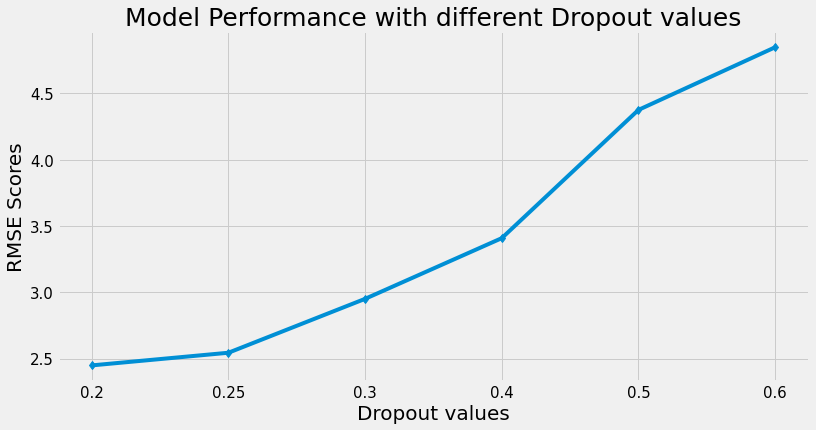

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Model Performance with different Dropout values", fontsize=25)
plt.plot(dropout_rmse_df['Dropout'], dropout_rmse_df['RMSE Scores'], marker='d')
plt.xlabel("Dropout values", fontsize=20)
plt.ylabel("RMSE Scores", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 2. Excluding dropout in LSTM layers

In [ ]:
#Build model
def build_model(dropout):
  model = Sequential()
  model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES)))
  model.add(Dense(units=128))
  model.add(Dropout(dropout))
  model.add(Dense(units=64))
  model.add(Dropout(0.5))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
model_cnt=1
mean_rmse_scores_excluding = []
dropout_list = [0.2, 0.25, 0.3, 0.4, 0.5, 0.6]
for dropout in dropout_list:
    rmse_scores = []
    for i in range(5):
        print("Training model : {}/30".format(model_cnt))
        model = build_model(dropout)
        model.fit(X_tr, y_tr,
                epochs=EPOCHS,
                batch_size=16,
                validation_data=(X_val, y_val),
                callbacks=[earlyStopping()],
                verbose=2
                )
        # Prediction
        y_preds = model.predict(X_test)
        rmse_scores.append(rmse(y_preds, y_test))
        model_cnt+=1
    mean_rmse_scores_excluding.append(np.mean(rmse_scores))

Training model : 1/30
Epoch 1/1000
107/107 - 1s - loss: 952.6826 - val_loss: 256.3417
Epoch 2/1000
107/107 - 1s - loss: 122.6572 - val_loss: 18.4284
Epoch 3/1000
107/107 - 1s - loss: 49.4634 - val_loss: 7.8381
Epoch 4/1000
107/107 - 1s - loss: 35.9456 - val_loss: 5.9688
Epoch 5/1000
107/107 - 1s - loss: 39.2341 - val_loss: 5.2583
Epoch 6/1000
107/107 - 1s - loss: 35.6047 - val_loss: 8.2432
Epoch 7/1000
107/107 - 1s - loss: 34.6765 - val_loss: 8.0341
Epoch 8/1000
107/107 - 1s - loss: 33.6836 - val_loss: 4.6224
Epoch 9/1000
107/107 - 1s - loss: 34.9238 - val_loss: 4.5391
Epoch 10/1000
107/107 - 1s - loss: 34.3795 - val_loss: 3.0306
Epoch 11/1000
107/107 - 1s - loss: 35.9899 - val_loss: 6.6721
Epoch 12/1000
107/107 - 1s - loss: 33.5768 - val_loss: 7.9159
Epoch 13/1000
107/107 - 1s - loss: 32.1984 - val_loss: 7.0104
Epoch 14/1000
107/107 - 1s - loss: 34.5252 - val_loss: 5.2719
Epoch 15/1000
107/107 - 1s - loss: 32.2128 - val_loss: 2.4280
Epoch 16/1000
107/107 - 1s - loss: 33.9970 - val_los

In [ ]:
# Scoring Dataframe (with dropout in LSTM)
dropout_rmse_df = pd.DataFrame({"Dropout" : [str(x) for x in dropout_list],
                                "RMSE Scores" : mean_rmse_scores_excluding
                               })
dropout_rmse_df.sort_values(by="RMSE Scores")

,Dropout,RMSE Scores
1,0.25,1.523524
2,0.3,1.574030
0,0.2,1.580923
3,0.4,1.582420
5,0.6,1.701274
4,0.5,1.733006


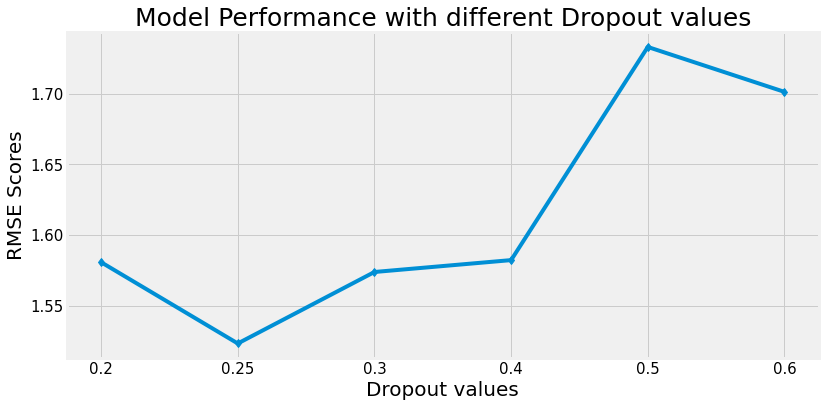

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Model Performance with different Dropout values", fontsize=25)
plt.plot(dropout_rmse_df['Dropout'], dropout_rmse_df['RMSE Scores'], marker='d')
plt.xlabel("Dropout values", fontsize=20)
plt.ylabel("RMSE Scores", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### A Dropout of 0.2 & 0.25 performs the best in case 1 and case 2 respectively but fails to beat the benchmark score. Hence we won't include dropout in our model.

## Experiment with Batch Normalization

Let's see if adding Batch Norm before Activation layer helps improve performance of model...

In [ ]:
# def build_model():
#   model = Sequential()
#   model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES), return_sequences=True))
#   model.add(LSTM(units=3))
#   model.add(Dense(units=64))
#   model.add(BatchNormalization())
#   model.add(Activation('tanh'))
#   model.add(Dense(units=32))
#   model.add(BatchNormalization())
#   model.add(Activation('tanh'))
#   model.add(Dense(units=16))
#   model.add(BatchNormalization())
#   model.add(Activation('tanh'))
#   model.add(Dense(units=1))
#   model.compile(loss='mean_squared_error', optimizer='adam')
#   return model

In [ ]:
# model_cnt=1
# rmse_scores = []
# for i in range(5):
#     print("Training model : {}/5".format(model_cnt))
#     model = build_model()
#     model.fit(X_tr, y_tr,
#             epochs=EPOCHS,
#             batch_size=16,
#             validation_data=(X_val, y_val),
#             callbacks=[earlyStopping()],
#             verbose=2
#             )
#     # Prediction
#     y_preds = model.predict(X_test)
#     rmse_scores.append(rmse(y_preds, y_test))
#     model_cnt+=1
# print("RMSE score with Batch Normalization is = {:.5f}".format(np.mean(rmse_scores)))

Training model : 1/5


TypeError: ignored

In [ ]:
# print("Mean RMSE score is : {:.2f}".format(np.mean(rmse_scores)))

Adding Batch Normalization layer doesn't improve model performance. So, we do not include it in our model.

## Experiment for choosing the Optimizer

Let's see which optimization is best for our model.

Optimizers = [Adam, SGD, Adadelta, Adamax, Adagrad, RMSProp]

Total 30 models to train => 6 optimizers * 5 iterations each

In [ ]:
def build_model(optimizer):
  model = Sequential()
  model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES)))
  model.add(Dense(units=128))
  model.add(Dense(units=64))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model

In [ ]:
# Optimizers
adam = Adam()
adagrad = Adagrad()
adamax = Adamax()
adadelta = Adadelta()
rmsprop = RMSprop()
sgd = SGD(lr=1e-3)

In [ ]:
model_cnt = 1
mean_rmse_scores = []
optimizers_list = [sgd ,adam, adagrad, adamax, adadelta, rmsprop]
for optimizer in optimizers_list:
  rmse_scores = []
  for i in range(5):
    print("Training model : {}/30".format(model_cnt))
    model = build_model(optimizer)
    model.fit(X_tr, y_tr,
              epochs=EPOCHS,
              batch_size=32,
              callbacks=[earlyStopping()],
              validation_data=(X_val, y_val),
              verbose=2
            )
    # Prediction
    y_preds = model.predict(X_test)
    rmse_scores.append(rmse(y_preds, y_test))
    model_cnt+=1
  mean_rmse_scores.append(np.mean(rmse_scores))

Streaming output truncated to the last 5000 lines.
54/54 - 0s - loss: 230.3706 - val_loss: 191.6087
Epoch 662/1000
54/54 - 0s - loss: 230.2910 - val_loss: 191.5004
Epoch 663/1000
54/54 - 0s - loss: 230.2094 - val_loss: 191.3792
Epoch 664/1000
54/54 - 0s - loss: 230.1258 - val_loss: 191.2452
Epoch 665/1000
54/54 - 0s - loss: 230.0425 - val_loss: 191.1069
Epoch 666/1000
54/54 - 0s - loss: 229.9549 - val_loss: 190.9677
Epoch 667/1000
54/54 - 0s - loss: 229.8653 - val_loss: 190.8127
Epoch 668/1000
54/54 - 0s - loss: 229.7731 - val_loss: 190.6812
Epoch 669/1000
54/54 - 0s - loss: 229.6855 - val_loss: 190.5637
Epoch 670/1000
54/54 - 0s - loss: 229.5937 - val_loss: 190.4252
Epoch 671/1000
54/54 - 0s - loss: 229.5067 - val_loss: 190.3171
Epoch 672/1000
54/54 - 0s - loss: 229.4266 - val_loss: 190.2179
Epoch 673/1000
54/54 - 0s - loss: 229.3495 - val_loss: 190.1218
Epoch 674/1000
54/54 - 0s - loss: 229.2666 - val_loss: 190.0169
Epoch 675/1000
54/54 - 0s - loss: 229.1815 - val_loss: 189.9038
Epoc

In [ ]:
# Scoring dataframe
Optimizers_labels = ['sgd' ,'adam', 'adagrad', 'adamax', 'adadelta', 'rmsprop']
optimizer_df = pd.DataFrame({'Optimizer' : Optimizers_labels,
                             'RMSE Scores' :  mean_rmse_scores
                            })
optimizer_df.sort_values('RMSE Scores')

,Optimizer,RMSE Scores
1,adam,1.164362
3,adamax,1.266062
5,rmsprop,1.329186
0,sgd,1.442412
2,adagrad,1.708123
4,adadelta,5.821257


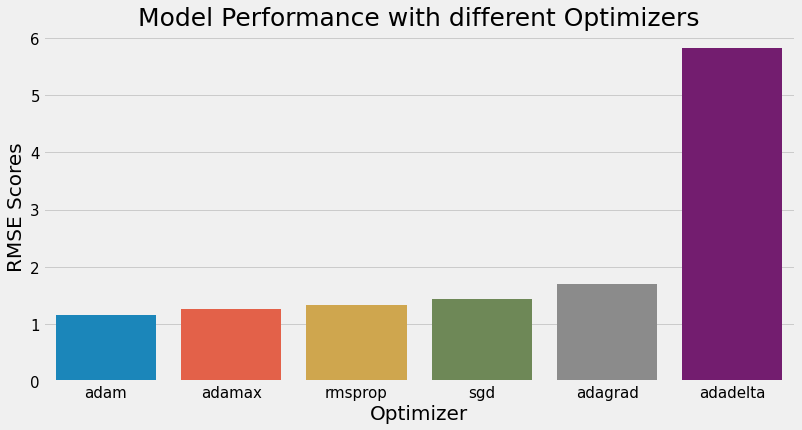

In [ ]:
plt.figure(figsize=(12,6))
sorted_df = optimizer_df.sort_values('RMSE Scores')
plt.title("Model Performance with different Optimizers", fontsize=25)
# plt.plot(optimizer_df['Optimizer'], optimizer_df['RMSE Scores'], marker='d')
sns.barplot(sorted_df['Optimizer'], sorted_df['RMSE Scores'])
plt.xlabel("Optimizer", fontsize=20)
plt.ylabel("RMSE Scores", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## We can confirm visually that <u>Adam optimizer performed the best</u> out of all optimizers. 

# Final Model + Training

Here we will combine all the findings from experiment and prepare our final model to train.

In [ ]:
def final_model():
  model = Sequential()
  model.add(LSTM(units=3, input_shape=(X_train.shape[1], NUM_FEATURES)))
  model.add(Dense(units=128))
  model.add(Dense(units=64))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

We will use K-Fold cross validation to validate our model while training.

In [ ]:
NFOLDS=5
kf = KFold(n_splits=NFOLDS, random_state=42)

In [ ]:
models_list = []
history_list = []
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
    print("\nFOLD : {}\n".format(fold+1))
    X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    X_val, y_val = X_train[val_idx], y_train[val_idx]
    
    model = final_model()
    history = model.fit(X_tr, y_tr,
                        epochs=EPOCHS,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[earlyStopping()],
                        verbose=2
                       )
    # Store model info and model
    history_list.append(history)
    models_list.append(model)


FOLD : 1

Epoch 1/1000
54/54 - 1s - loss: 1530.2120 - val_loss: 759.3593
Epoch 2/1000
54/54 - 0s - loss: 429.4747 - val_loss: 199.0443
Epoch 3/1000
54/54 - 0s - loss: 111.2621 - val_loss: 39.9711
Epoch 4/1000
54/54 - 0s - loss: 29.3337 - val_loss: 19.3361
Epoch 5/1000
54/54 - 0s - loss: 15.8054 - val_loss: 11.3333
Epoch 6/1000
54/54 - 0s - loss: 9.6126 - val_loss: 6.7930
Epoch 7/1000
54/54 - 0s - loss: 6.3444 - val_loss: 4.8751
Epoch 8/1000
54/54 - 0s - loss: 5.1820 - val_loss: 4.0177
Epoch 9/1000
54/54 - 0s - loss: 4.5459 - val_loss: 3.5395
Epoch 10/1000
54/54 - 0s - loss: 3.9768 - val_loss: 3.0682
Epoch 11/1000
54/54 - 0s - loss: 3.6747 - val_loss: 2.8023
Epoch 12/1000
54/54 - 0s - loss: 3.4047 - val_loss: 2.6452
Epoch 13/1000
54/54 - 0s - loss: 3.1707 - val_loss: 2.7342
Epoch 14/1000
54/54 - 0s - loss: 3.0407 - val_loss: 2.4141
Epoch 15/1000
54/54 - 0s - loss: 2.9273 - val_loss: 2.3508
Epoch 16/1000
54/54 - 0s - loss: 2.8702 - val_loss: 2.3628
Epoch 17/1000
54/54 - 0s - loss: 2.808

## Choosing best model based on foldwise mean validation loss score

In [ ]:
mean_rmse_scores = []
for i in range(NFOLDS):
    mean_rmse_scores.append(np.mean(history_list[i].history['val_loss']))

best_val_loss_idx = np.argmin(mean_rmse_scores)
best_model = models_list[best_val_loss_idx]

# Prediction

In [ ]:
# Predictions
y_preds = best_model.predict(X_test)

# Computing the RMSE
rmse_score = rmse(y_preds, y_test)
print("RMSE score : {}".format(rmse_score))

RMSE score : 1.1068461951882325


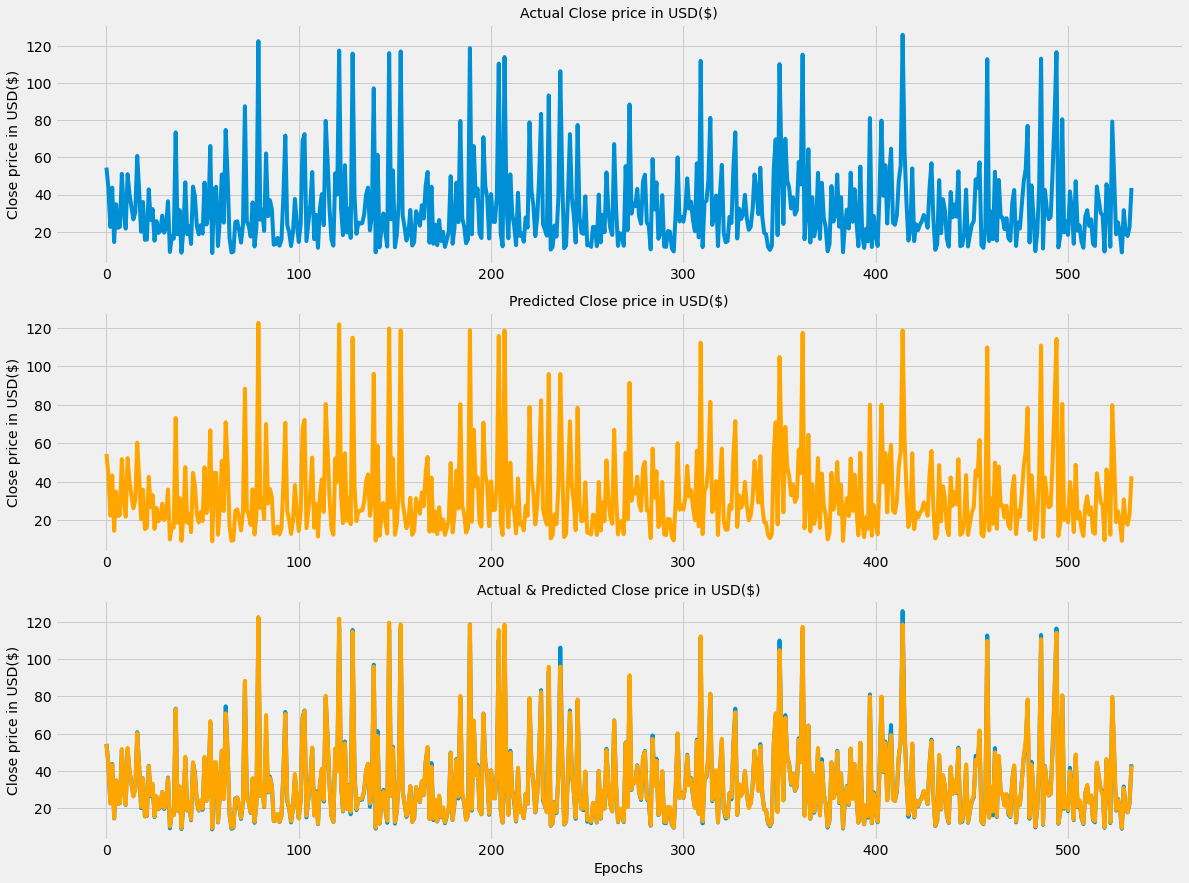

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(18,14))
ax[0].set_title("Actual Close price in USD($)", fontsize=14)
ax[0].plot(y_test)
ax[0].set_ylabel("Close price in USD($)", fontsize=14)
ax[1].set_title("Predicted Close price in USD($)", fontsize=14)
ax[1].plot(y_preds, color='orange')
ax[1].set_ylabel("Close price in USD($)", fontsize=14)
ax[2].set_title("Actual & Predicted Close price in USD($)", fontsize=14)
ax[2].plot(y_test)
ax[2].plot(y_preds, color='orange')
ax[2].set_xlabel("Epochs", fontsize=14)
ax[2].set_ylabel("Close price in USD($)", fontsize=14)
plt.show()

# Save the Best Model & Scaler


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Saving model
save_path = '/content/gdrive/My Drive/Stock Price Forecasting/'
modelfilename = save_path + ticker + "_SPF_model"
best_model.save(modelfilename)

# Save Scaler
filename = save_path + ticker + "_spf_scaler.pkl"
with open(filename, 'wb') as f:
    pickle.dump(scaler, f)
    f.close()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Stock Price Forecasting/AAPL_SPF_model/assets


# Forecasting next day stock prices

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# Making prediction for next day stock price.(t+1) i.e. next day to the current day

# Get the stock price data and store in temp datagframe
temp_df = df.iloc[len(df)-90 : len(df), :]

# get 'Close' price and covert to numpy ndarray
user_data = temp_df['Close'].values

# Load model and scaler
model_path = '/content/gdrive/My Drive/Stock Price Forecasting/AAPL_SPF_model'
scaler_path = '/content/gdrive/My Drive/Stock Price Forecasting/AAPL_spf_scaler.pkl'
model = load_model(model_path)
f = open(scaler_path, 'rb')
scaler = pickle.load(f)

# Scale the data 
user_data = user_data.reshape(1, user_data.shape[0])
user_data = scaler.transform(user_data)

# Convert shape and form of data that is accepted by LSTM RNN
user_data = np.reshape(user_data, (user_data.shape[0], user_data.shape[1], 1))

# Predict next day stock price
prediction = model.predict(user_data)
print(prediction)

[[122.48937]]


# What all is yet to be tried..
- Try scaling b/w -1 & 1
- Learning Rate
- Try stateful/ stateless LSTMs
- EDA
- Try predicting for a range of 1 day to 7 days
- Why some tickers worked and some not...
- Try Qunatile regression outputs
- Why train and val loss have huge difference

# Reference 
1. https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm?newreg=6c00ae0cda854cb29423e93bddaca622

2. https://medium.com/datadriveninvestor/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577 

3. https://colab.research.google.com/notebooks/io.ipynb#scrollTo=D78AM1fFt2ty

# Things I tested
- Vanilla/ Stacked/ Bidirectional
- Batch Size
- Epochs (Early Stopping)
- No. of Neurons and LSTM layers
- No. of dense units and dense layers
- Activation functions
- Dropout and Batch Norm
- Cross Validation
- Shuffling data
- Optimization algos

